<a href="https://colab.research.google.com/github/Rizkiramdani04/Portofolio_DS_DA/blob/main/Sloan_Digital_Sky_Survey_Classification_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
from sklearn.model_selection import train_test_split,cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score
import time
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)
%matplotlib inline
SMALL_SIZE=10
MEDIUM_SIZE=12
plt.rc('font',size=SMALL_SIZE)
plt.rc('axes',titlesize=MEDIUM_SIZE)
plt.rc('axes',labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

In [ ]:
data = pd.read_csv('/content/Salinan sdss_data_classification (2).csv', skiprows=0)

In [ ]:
data.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


In [ ]:
data.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.237650e+18,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,981.034800,301.0,3.648700,302.380100,1.645022e+18,0.143726,1460.986400,52943.533300,353.069400
std,1.577039e+05,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,273.305024,0.0,1.666183,162.577763,2.013998e+18,0.388774,1788.778371,1511.150651,206.298149
min,1.237650e+18,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,301.0,1.000000,11.000000,2.995780e+17,-0.004136,266.000000,51578.000000,1.000000
25%,1.237650e+18,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,752.000000,301.0,2.000000,184.000000,3.389248e+17,0.000081,301.000000,51900.000000,186.750000
50%,1.237650e+18,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,756.000000,301.0,4.000000,299.000000,4.966580e+17,0.042591,441.000000,51997.000000,351.000000
75%,1.237650e+18,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,1331.000000,301.0,5.000000,414.000000,2.881300e+18,0.092579,2559.000000,54468.000000,510.000000
max,1.237650e+18,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,1412.000000,301.0,6.000000,768.000000,9.468830e+18,5.353854,8410.000000,57481.000000,1000.000000


In [ ]:
data['class'].value_counts()

,count
class,
GALAXY,4998
STAR,4152
QSO,850


In [ ]:
data.columns.values

array(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun',
       'camcol', 'field', 'specobjid', 'class', 'redshift', 'plate',
       'mjd', 'fiberid'], dtype=object)

In [ ]:
data.drop(['objid','run','rerun','camcol','field','specobjid'],axis=1,inplace=True)
data.head()

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,STAR,-0.000009,3306,54922,491
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,STAR,-0.000055,323,51615,541
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,GALAXY,0.123111,287,52023,513
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,STAR,-0.000111,3306,54922,510
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,STAR,0.000590,3306,54922,512


<ipython-input-21-2fe184fb879b>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax=sns.distplot(data[data['class']=='STAR'].redshift,bins=15,ax=axes[0],kde=False)
<ipython-input-21-2fe184fb879b>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax=sns.distplot(data[data['class']=='GALAXY'].redshift,bins=15,ax=axes[1],kde

Text(0.5, 1.0, 'Qso')

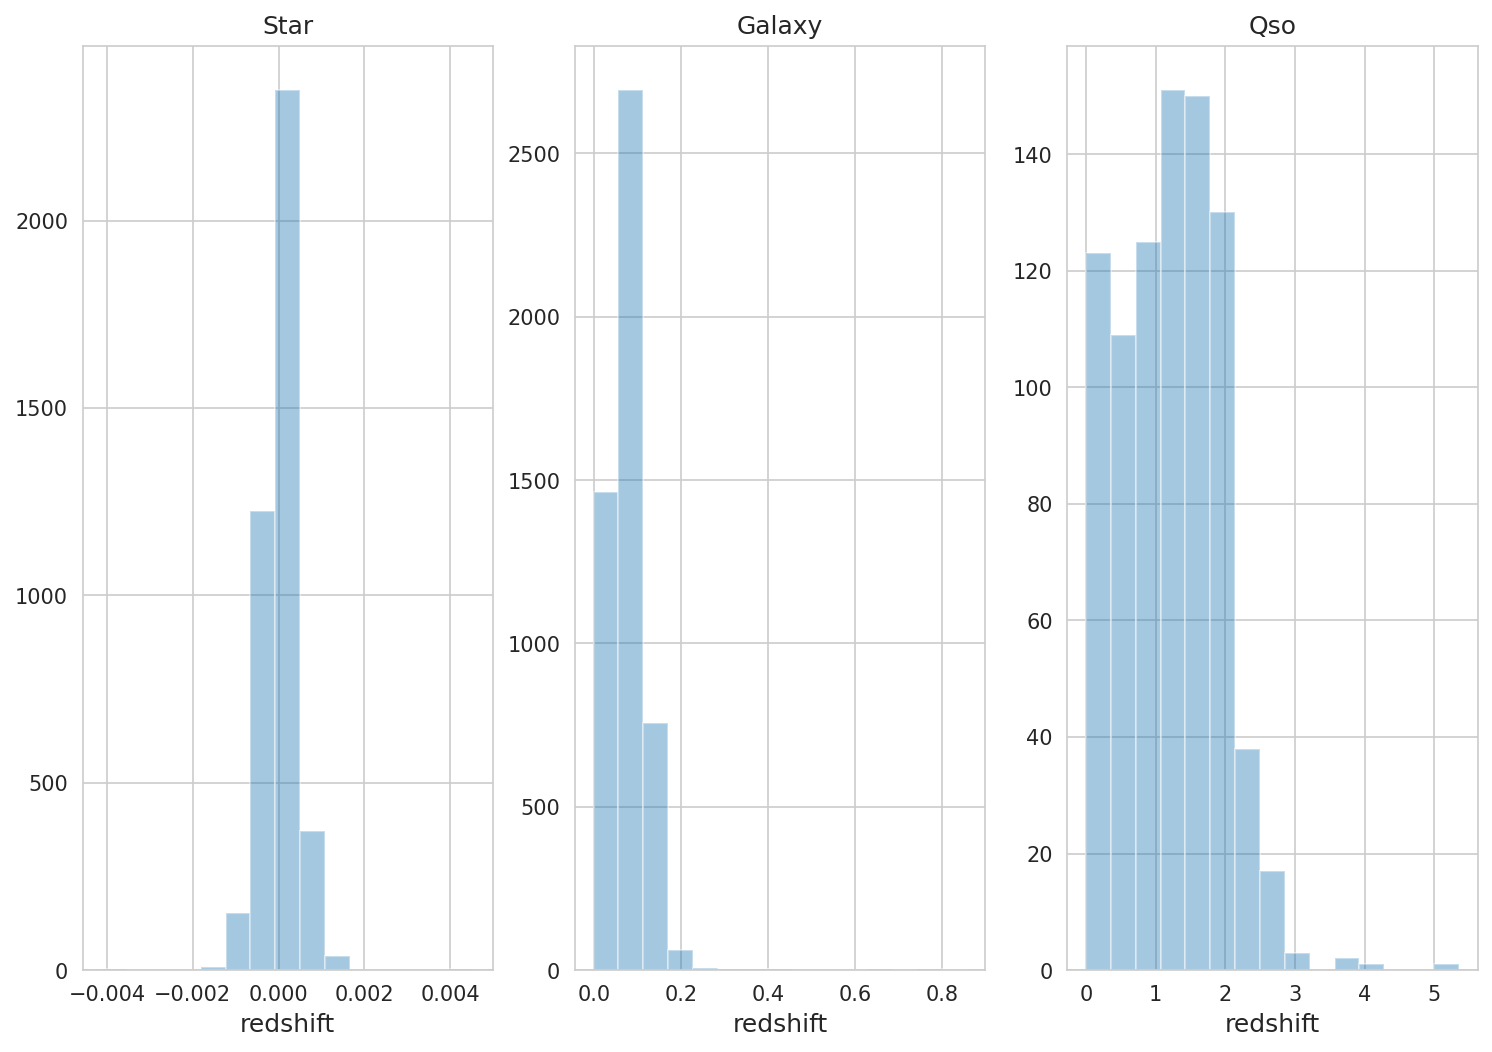

In [ ]:
fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(12,8))
ax=sns.distplot(data[data['class']=='STAR'].redshift,bins=15,ax=axes[0],kde=False)
ax.set_title("Star")
ax=sns.distplot(data[data['class']=='GALAXY'].redshift,bins=15,ax=axes[1],kde=False)
ax.set_title('Galaxy')
ax=sns.distplot(data[data['class']=='QSO'].redshift,bins=15,ax=axes[2],kde=False)
ax.set_title('Qso')

<ipython-input-22-3405cf52759e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.boxplot(x=data['class'],y=data['dec'],palette='coolwarm')


<function matplotlib.pyplot.show(close=None, block=None)>

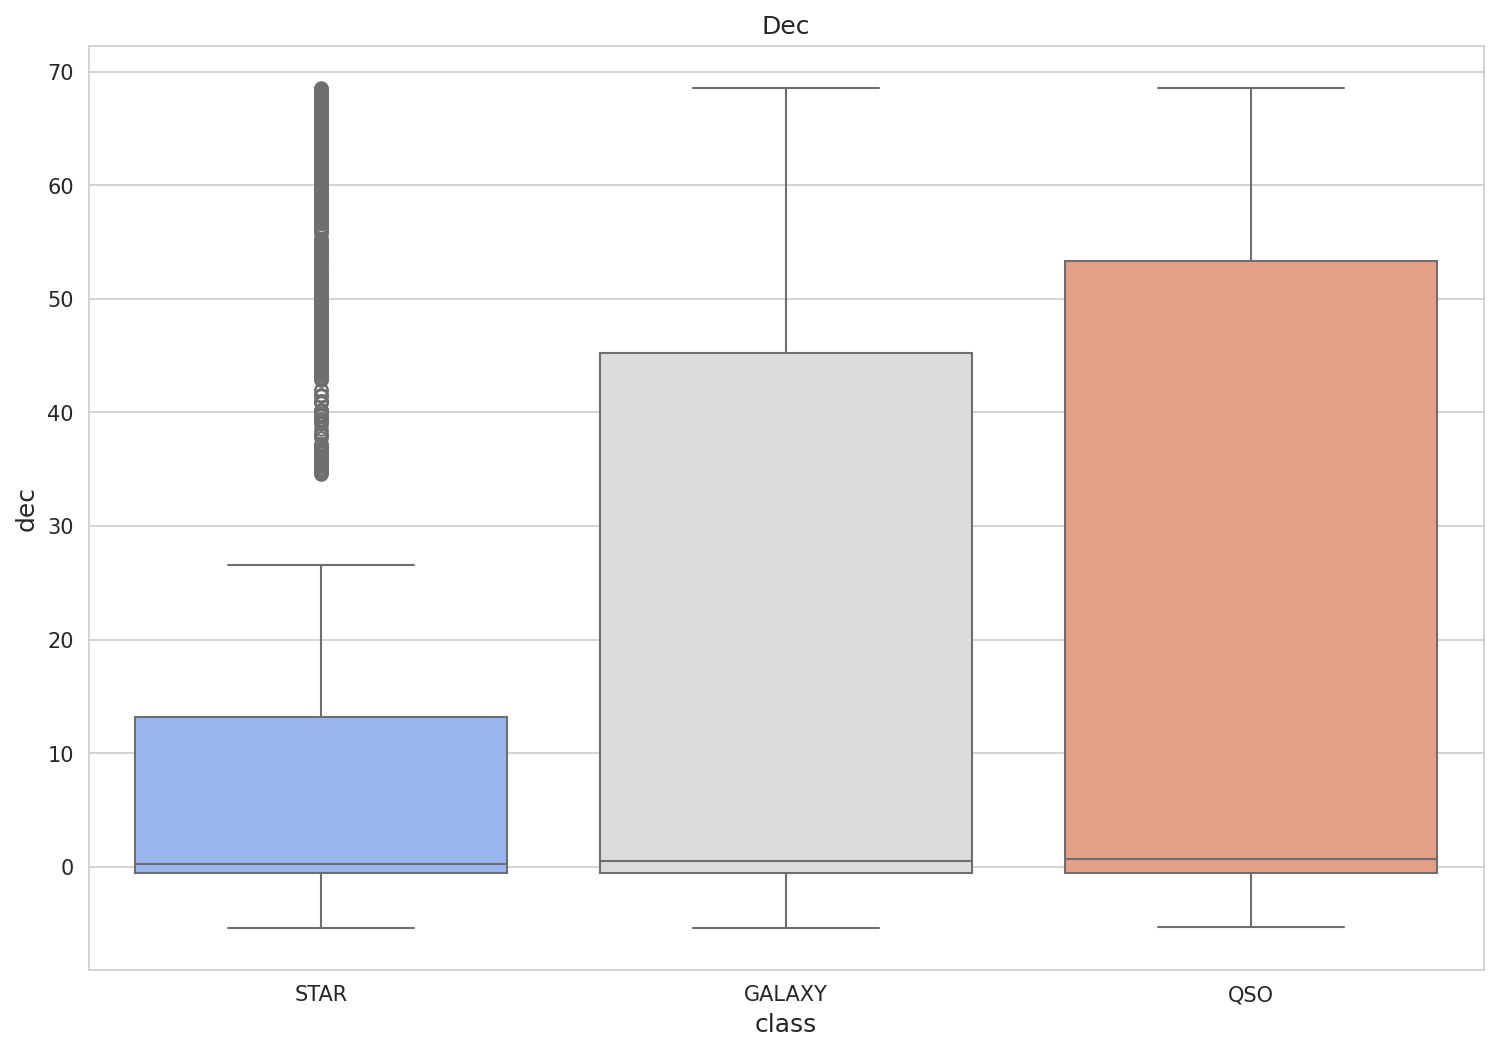

In [ ]:
fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(12,8))
ax=sns.boxplot(x=data['class'],y=data['dec'],palette='coolwarm')
ax.set_title('Dec')
plt.show

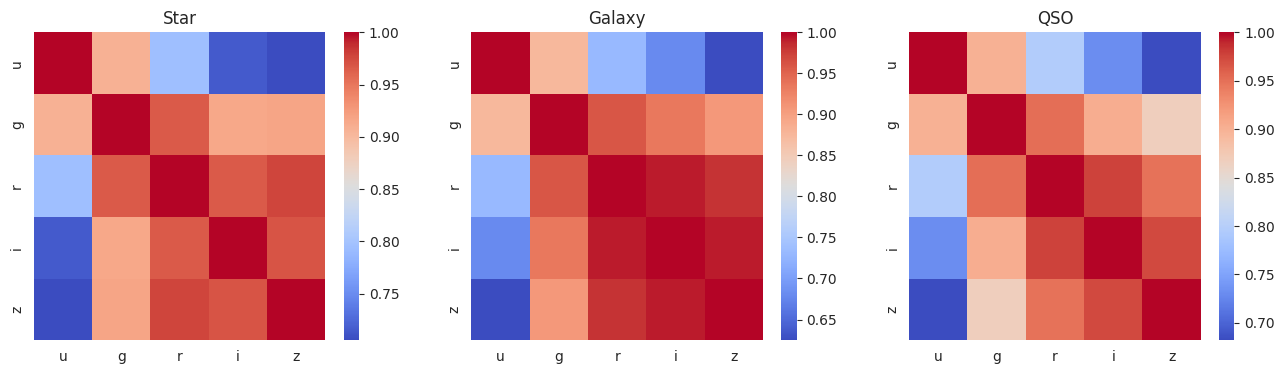

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
fig.set_dpi(100)
ax = sns.heatmap(data[data['class']=='STAR'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[0], cmap='coolwarm')
ax.set_title('Star')
ax = sns.heatmap(data[data['class']=='GALAXY'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[1], cmap='coolwarm')
ax.set_title('Galaxy')
ax = sns.heatmap(data[data['class']=='QSO'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[2], cmap='coolwarm')
ax = ax.set_title('QSO')

Text(0.5, 1.0, 'Equatorial Coordinates')

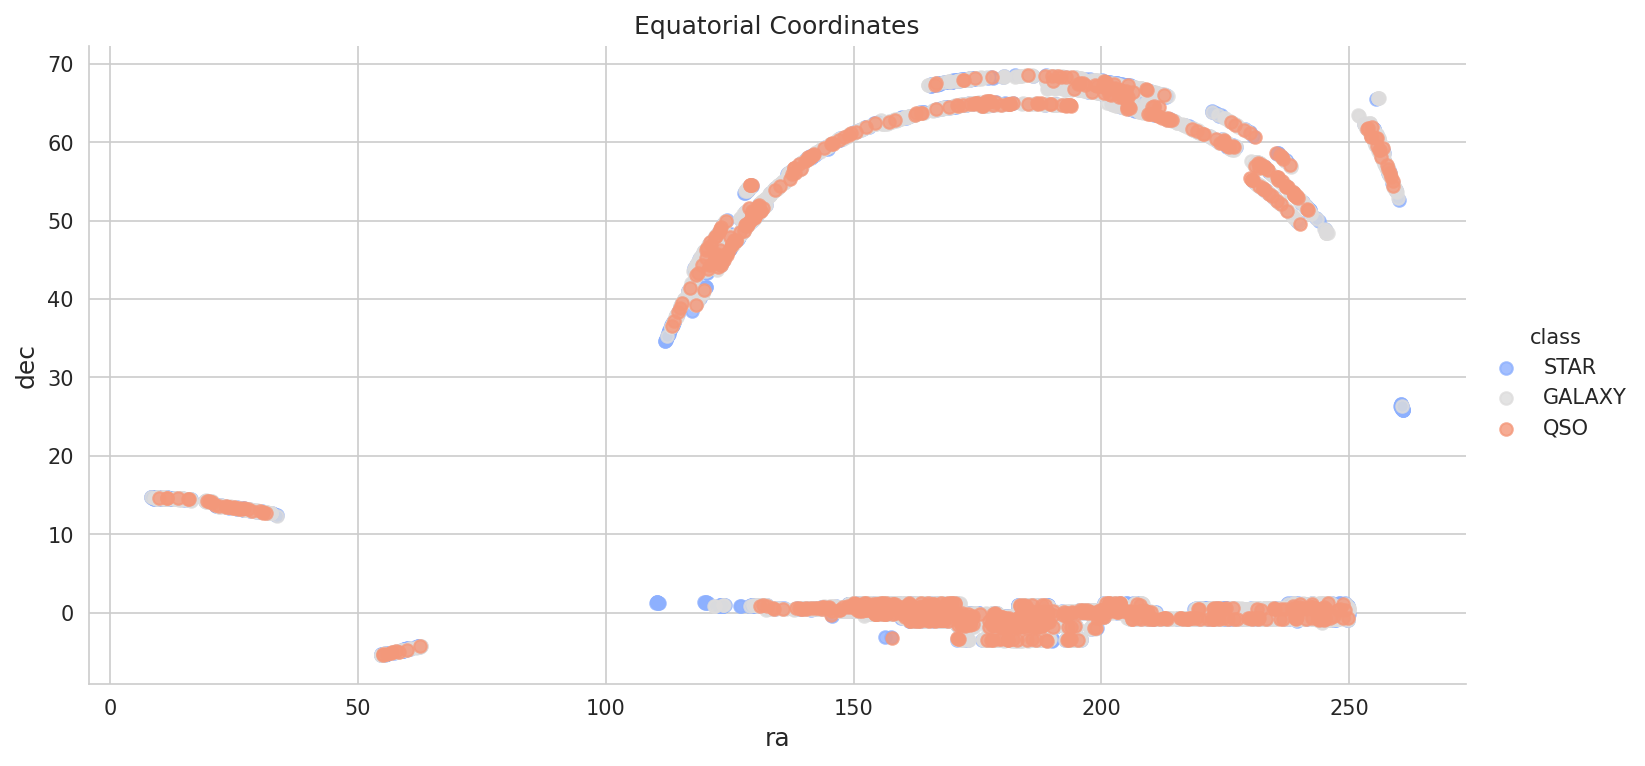

In [ ]:
sns.lmplot(x='ra',y='dec',data=data,hue='class',fit_reg=False,palette='coolwarm',aspect=2)
plt.title('Equatorial Coordinates')

In [ ]:
dataset=data
le=LabelEncoder()
y_encoded=le.fit_transform(dataset['class'])
dataset['class']=y_encoded
pca=PCA(n_components=3)
ugriz=pca.fit_transform(dataset[['u','g','r','i','z']])
dataset=pd.concat((dataset,pd.DataFrame(ugriz)),axis=1)
dataset.rename({0:'PCA_1',1:'PCA_2',2:'PCA_3'},axis=1,inplace=True)
dataset.drop(['u','g','r','i','z'],axis=1,inplace=True)
dataset.head()

,ra,dec,class,redshift,plate,mjd,fiberid,PCA_1,PCA_2,PCA_3
0,183.531326,0.089693,2,-0.000009,3306,54922,491,-1.507202,1.377293,-0.265119
1,183.598370,0.135285,2,-0.000055,323,51615,541,-0.195758,0.028410,-0.155695
2,183.680207,0.126185,0,0.123111,287,52023,513,1.297604,0.590023,0.140338
3,183.870529,0.049911,2,-0.000111,3306,54922,510,-1.446117,-0.566685,-0.009272
4,183.883288,0.102557,2,0.000590,3306,54922,512,-0.849271,-1.287505,-0.397689


In [ ]:
scaler=MinMaxScaler()
data1=scaler.fit_transform(dataset.drop('class',axis=1))

In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(data1,dataset['class'],test_size=0.2,random_state=42)

##XGBOOST

In [ ]:
xgb=XGBClassifier(n_estimators=100)
training_start=time.perf_counter()
xgb.fit(X_train,Y_train)
training_end=time.perf_counter()
prediction_start=time.perf_counter()
preds=xgb.predict(X_test)
prediction_end=time.perf_counter()
acc_xgb=(preds==Y_test).sum().astype(float)/len(preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

XGBoost's prediction accuracy is: 99.45
Time consumed for training: 0.423
Time consumed for prediction: 0.01112 seconds


In [ ]:
importances = pd.DataFrame({
    'Feature': dataset.drop('class', axis=1).columns,
    'Importance': xgb.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
redshift,0.931886
PCA_3,0.022290
PCA_2,0.009593
plate,0.007826
PCA_1,0.006364
mjd,0.006187
ra,0.005683
fiberid,0.005333
dec,0.004839


<Axes: xlabel='Feature'>

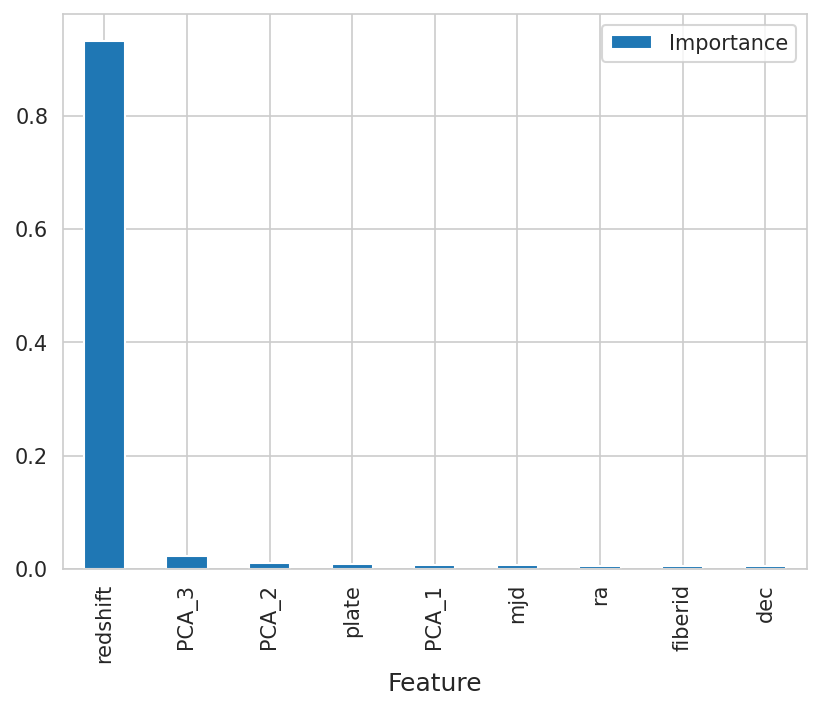

In [ ]:
importances.plot.bar()

## Confusion Matrix

In [ ]:
confusion_matrix(Y_test,preds)

array([[990,   3,   3],
       [  4, 186,   0],
       [  1,   0, 813]])

##Precision & Recall

In [ ]:
print("Precision:", precision_score(Y_test, preds, average='micro'))
print("Recall:",recall_score(Y_test, preds, average='micro'))

Precision: 0.9945
Recall: 0.9945


## F1 Score

In [ ]:
print("F1-Score:", f1_score(Y_test, preds, average='micro'))

F1-Score: 0.9945
